##### New Master, TD(lambda) #

Best version was already fast, but not fast enough. Next try is with bigger alpha in the beginning

parameters: 

alpha:
        if episode < 20:
            return 0.65
        else:
            return 0.5

gamma: 
        max(1.0-episode/200, 0.2)
        
epsilon:
        max(0.1-episode/200, 0.001)
        



In [1]:
import gym
import os
import numpy as np
os.environ["DISPLAY"] = ":0"

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random as random


In [2]:
class tileModel:
    def __init__(self, env,nbTilings, gridSize):
        # characteristica of observation
        self.obsHigh = env.observation_space.high
        self.obsLow = env.observation_space.low
        self.obsDim = len(self.obsHigh)
        
        # characteristica of tile model
        self.nbTilings = nbTilings
        self.gridSize = gridSize
        self.gridWidth = np.divide(np.subtract(self.obsHigh,self.obsLow), self.gridSize)
        self.nbTiles = (self.gridSize**self.obsDim) * self.nbTilings
        self.nbTilesExtra = (self.gridSize**self.obsDim) * (self.nbTilings+1)
        
        #state space
        self.nbActions = env.action_space.n
        self.resetStates()
        
    def resetStates(self):
        ### self.states = np.random.uniform(low=0.0, high=0.0001, size=(self.nbTilesExtra,self.nbActions))
        self.states = np.zeros([self.nbTilesExtra,self.nbActions])
        
        
    def displayM(self):
        print('observation:\thigh:', self.obsHigh, 'low:', self.obsLow, 'dim:',self.obsDim )
        print('tile model:\tnbTilings:', self.nbTilings, 'gridSize:',self.gridSize, 'gridWidth:',self.gridWidth,'nb tiles:', self.nbTiles )
        print('state space:\tnb of actions:', self.nbActions, 'size of state space:', self.nbTiles)
        
    def code (self, obsOrig):
        #shift the original observation to range [0, obsHigh-obsLow]
        #scale it to the external grid size: if grid is 8*8, each range is [0,8]
        obsScaled = np.divide(np.subtract(obsOrig,self.obsLow),self.gridWidth)
        ### print ('\noriginal obs:',obsOrig,'shifted and scaled obs:', obsScaled )
        
        #compute the coordinates/tiling
        #each tiling is shifted by tiling/gridSize, i.e. tiling*1/8 for grid 8*8
        #and casted to integer
        coordinates = np.zeros([self.nbTilings,self.obsDim])
        tileIndices = np.zeros(self.nbTilings)
        for tiling in range(self.nbTilings):
            coordinates[tiling,:] = obsScaled + tiling/ self.nbTilings
        coordinates=np.floor(coordinates)
        
        #this coordinates should be used to adress a 1-dimensional status array
        #for 8 tilings of 8*8 grid we use:
        #for tiling 0: 0-63, for tiling 1: 64-127,...
        coordinatesOrg=np.array(coordinates, copy=True)        
        ### print ('coordinates:', coordinates)
        
        for dim in range(1,self.obsDim):
            coordinates[:,dim] *= self.gridSize**dim
        ### print ('coordinates:', coordinates)
        condTrace=False
        for tiling in range(self.nbTilings):
            tileIndices[tiling] = (tiling * (self.gridSize**self.obsDim) \
                                   + sum(coordinates[tiling,:])) 
            if tileIndices[tiling] >= self.nbTilesExtra:
                condTrace=True
                
        if condTrace:
            print("code: obsOrig:",obsOrig, 'obsScaled:', obsScaled, "coordinates w/o shift:\n", coordinatesOrg )
            print ("coordinates multiplied with base:\n", coordinates, "\ntileIndices:", tileIndices)
        ### print ('tileIndices:', tileIndices)
        ### print ('coordinates-org:', coordinatesOrg)
        return coordinatesOrg, tileIndices
    
    def getQ(self,state):
        Q=np.zeros(self.nbActions)
        _,tileIndices=self.code(state)
        ### print ('getQ-in : state',state,'tileIndices:', tileIndices)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            Q=np.add(Q,self.states[index])
        ### print ('getQ-out : Q',Q)
        ## Q=np.divide(Q,self.nbTilings)
        return Q
    
    def updateQ(self, state, action, deltaQA):
        _,tileIndices=self.code(state)
        ### print ('updateQ-in : state',state,'tileIndices:', tileIndices,'action:', action, 'deltaQA:', deltaQA)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            self.states[index,action]+=deltaQA
            ### print ('updateQ: index:', index, 'states[index]:',self.states[index])
            
    def preparePlot(self):
        plotInput=np.zeros([self.gridSize*self.nbTilings, self.gridSize*self.nbTilings,self.nbActions])    #pos*velo*actions
        iTiling=0
        iDim1=0                 #velocity
        iDim0=0                 #position
        ### tileShift=1/self.nbTilings
        
        for i in range(self.nbTiles):
            ### print ('i:',i,'iTiling:',iTiling,'iDim0:',iDim0, 'iDim1:', iDim1 ,'state:', self.states[i])
            for jDim0 in range(iDim0*self.nbTilings-iTiling, (iDim0+1)*self.nbTilings-iTiling):
                for jDim1 in range(iDim1*self.nbTilings-iTiling, (iDim1+1)*self.nbTilings-iTiling):
                    ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state before:', plotInput[jDim0,jDim1] )
                    if jDim0>0 and jDim1 >0:
                        plotInput[jDim0,jDim1]+=self.states[i]
                        ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state after:', plotInput[jDim0,jDim1] )
            iDim0+=1
            if iDim0 >= self.gridSize:
                iDim1 +=1
                iDim0 =0
            if iDim1 >= self.gridSize:
                iTiling +=1
                iDim0=0
                iDim1=0
                plotInput2 = np.array(plotInput, dtype=int)


        return plotInput
        
    def plot(self,ax):
        plotInput=np.zeros([self.gridSize*self.nbTilings, self.gridSize*self.nbTilings])    #pos*velo*actions
        iTiling=0
        iDim1=0                 #velocity
        iDim0=0                 #position
        ### tileShift=1/self.nbTilings
        
        for i in range(self.nbTiles):
            ### print ('i:',i,'iTiling:',iTiling,'iDim0:',iDim0, 'iDim1:', iDim1 ,'state:', self.states[i])
            for jDim0 in range(iDim0*self.nbTilings-iTiling, (iDim0+1)*self.nbTilings-iTiling):
                for jDim1 in range(iDim1*self.nbTilings-iTiling, (iDim1+1)*self.nbTilings-iTiling):
                    ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state before:', plotInput[jDim0,jDim1] )
                    if jDim0>0 and jDim1 >0:
                        plotInput[jDim0,jDim1]+=np.sum(self.states[i])
                        ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state after:', plotInput[jDim0,jDim1] )
            iDim0+=1
            if iDim0 >= self.gridSize:
                iDim1 +=1
                iDim0 =0
            if iDim1 >= self.gridSize:
                iTiling +=1
                iDim0=0
                iDim1=0
        
        plotInput2 = np.array(plotInput, dtype=int)


        ax.imshow(plotInput2, origin='lower',cmap='plasma')
        
        
            

    

In [3]:
class  eligibilityTraces:
    def __init__(self, tileModel):
        # characteristica of observation
        self.obsDim = tileModel.obsDim
        self.nbTiles=tileModel.nbTiles
        
        # characteristica of tile model
        self.nbTilings = tileModel.nbTilings
        self.gridSize = tileModel.gridSize
        self.nbTilesExtra = tileModel.nbTilesExtra
        
        #state space
        self.nbActions = tileModel.nbActions
        self.reset()
        
    def reset(self):
        self.states = np.zeros((self.nbTilesExtra,self.nbActions))
        #self.states = np.ones((self.nbTilesExtra,self.nbActions))

    def getE(self,tileModel, state):
        _,tileIndices=tileModel.code(state)
        ### print ('getE-in : state',state,'tileIndices:', tileIndices)

        E=np.zeros(self.nbActions)
        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            E=np.add(E,self.states[index])
        ### print ('getE-out : E',Q)
        E=np.divide(E,self.nbTilings)
        return E

    def addOne(self,tileModel, state,action):
        _,tileIndices=tileModel.code(state)
        ### print ('getE-in : state',state,'tileIndices:', tileIndices)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            self.states[index,action]+=1

    def multiply(self,mult):
        self.states*=mult
        
    def addDelta(self,tileModel,deltaQA):
        tileModel.states +=deltaQA*self.states
    
    def plotStates(self,ax):
        plotInput=np.zeros([self.gridSize*self.nbTilings, self.gridSize*self.nbTilings])    #pos*velo*actions
        iTiling=0
        iDim1=0                 #velocity
        iDim0=0                 #position
        ### tileShift=1/self.nbTilings
        
        for i in range(self.nbTiles):
            ### print ('i:',i,'iTiling:',iTiling,'iDim0:',iDim0, 'iDim1:', iDim1 ,'state:', self.states[i])
            for jDim0 in range(iDim0*self.nbTilings-iTiling, (iDim0+1)*self.nbTilings-iTiling):
                for jDim1 in range(iDim1*self.nbTilings-iTiling, (iDim1+1)*self.nbTilings-iTiling):
                    ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state before:', plotInput[jDim0,jDim1] )
                    if jDim0>0 and jDim1 >0:
                        plotInput[jDim0,jDim1]+=np.sum(self.states[i])
                        ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state after:', plotInput[jDim0,jDim1] )
            iDim0+=1
            if iDim0 >= self.gridSize:
                iDim1 +=1
                iDim0 =0
            if iDim1 >= self.gridSize:
                iTiling +=1
                iDim0=0
                iDim1=0
                
        plotInput2 = np.array(plotInput, dtype=int)
        ax.imshow(plotInput2, origin='lower',cmap='viridis')
        
        return plotInput



In [4]:
env = gym.make('MountainCar-v0')

tileModel  = tileModel(env,8,8)                     #grid: 8*8, 8 tilings
eligibilityTraces=eligibilityTraces(tileModel)

tileModel.displayM()


[2017-06-04 23:04:40,278] Making new env: MountainCar-v0


observation:	high: [ 0.6   0.07] low: [-1.2  -0.07] dim: 2
tile model:	nbTilings: 8 gridSize: 8 gridWidth: [ 0.225   0.0175] nb tiles: 512
state space:	nb of actions: 3 size of state space: 512


In [5]:
# configuration of framework and evaluation
nbCycles = 6
nbEpisodes = 850
nbTimesteps = 200
printEpisodeResult=False

# Policy parameter setting for the run
policySARSA=True             #T: SARSA, F: QLearning
sarsaLambda=0.2             # lambda= 0 => TD(0)
policy='test'
plotInterval=nbEpisodes+1

# strategies: -1: static, 0: 1/episode**2, 1:1/episode, 2: (1/2)**episode 3: 0.01 4: linear 9:0.1
if policy=='slow':
    policyP = {
        # Epsilon for epsilon-greedy
        'epsilon':{'strategy':4, 'static':0.01, 'start':0.1, 'base':0.05, 'interval':200},
        # Discount factor for Q(S',A')
        'gamma'  :{'strategy':-1, 'static':1.0,  'start':0.9, 'base':0.2,   'interval':200},
        # learning rate
        'alpha'  :{'strategy':6, 'static':1.0,  'start':1.0, 'base':0.2,   'interval':200}
    }
elif policy=='fast':                       #fast learner
    policyP = {
        # Epsilon for epsilon-greedy
        'epsilon':{'strategy':4, 'static':0.1, 'start':0.1, 'base':0.001, 'interval':200},
        # Discount factor for Q(S',A')
        'gamma'  :{'strategy':4, 'static':0.9,  'start':0.9, 'base':0.5,   'interval':200},
        # learning rate
        'alpha'  :{'strategy':7, 'static':0.5,  'start':1.0, 'base':0.2,   'interval':200}
    }
elif policy=='static':                       #fast learner
    policyP = {
        # Epsilon for epsilon-greedy
        'epsilon':{'strategy':-1, 'static':0.1, 'start':0.1, 'base':0.001, 'interval':200},
        # Discount factor for Q(S',A')
        'gamma'  :{'strategy':-1, 'static':1.0,  'start':0.9, 'base':0.5,   'interval':200},
        # learning rate
        'alpha'  :{'strategy':-1, 'static':0.5,  'start':1.0, 'base':0.2,   'interval':200}
    }
elif policy=='test':                       #fast learner
    policyP = {
        # Epsilon for epsilon-greedy
        'epsilon':{'strategy':4, 'static':0.1, 'start':0.75, 'base':0.005, 'interval':200},
        # Discount factor for Q(S',A')
        'gamma'  :{'strategy':-1, 'static':1.0,  'start':0.9, 'base':0.5,   'interval':200},
        # learning rate
        'alpha'  :{'strategy':-1, 'static':0.125,  'start':1.0, 'base':0.2,   'interval':200}
    }




In [6]:
class evaluation:
    def __init__(self, nbEpisodes, nbTimesteps):
        self.nbTimesteps=nbTimesteps
        self.nbEpisodes=nbEpisodes
        self.episodesEvaluated=100
        if nbEpisodes < self.episodesEvaluated:
            self.episodesEvaluated=int(nbEpisodes/2)+1
        self.rewardLimit=-110

        self.cycleFirstArrival=[]
        self.cycleArrivedNb=[]
        self.cycleArrivePrct=[]
        self.cycleRewardMax=[]
        self.cycleRewardMaxEpi=[]
        self.cycleAverageMax=[]
        self.cycleAverageMaxEpi=[]
        self.cycleRewAverages=[]
        self.cycleRewards=[]
        self.cycleProblemSolved=[]
        
        
        
        
        self.reset()
        print ('evaluation initialized')
        
    def reset(self):
        self.lastEpisode=-1
        self.arrivedNb=0                 #how often did the car arrive
        self.arrivedFirst=0              #which episode for the first time 
        self.rewardMax=-200              #max reward seen
        self.rewardMaxEpisode=0          #in which episode did we see the max reward
        self.rewardTracker = np.zeros(self.episodesEvaluated)
        self.rewardAverages=[]
        self.rewards=[]
        self.problemSolved=False
        self.averageMax=-200
        self.averageMaxEpisode=0
        self.lastAverage=-200
        print ('evaluation reset')
        
    def EpiTrack (self,episode, step, rwdAcc):
        self.lastEpisode=episode
        if rwdAcc>self.rewardMax:
            self.rewardMax=rwdAcc
            self.rewardMaxEpisode=episode
        self.rewards.append(rwdAcc)
            
        self.rewardTracker[episode%self.episodesEvaluated]=rwdAcc
        
        if episode>self.episodesEvaluated:
            self.lastAverage=np.average(self.rewardTracker)
        else:
            self.lastAverage=np.average(self.rewardTracker[0:episode+1])
            
        self.rewardAverages.append(self.lastAverage)
        if self.lastAverage>=self.rewardLimit:
            self.problemSolved=True
            
        if self.lastAverage>self.averageMax:
            self.averageMax=self.lastAverage
            self.averageMaxEpisode=episode
            
        if step < self.nbTimesteps-1:
            self.arrivedNb+=1
            if self.arrivedFirst==0:
                self.arrivedFirst=episode
                
    def EpiEval(self,episode,step):
        print('\rEpisode {} done: steps: {}, r-average: {:.1f}, arrived {}({:.1%}), maxReward: {} in {}, best average: {:.1f} in {}'.\
              format(episode, step+1, self.lastAverage, self.arrivedNb,self.arrivedNb/(episode+1), \
                     self.rewardMax, self.rewardMaxEpisode, self.averageMax,self.averageMaxEpisode),\
              end='')
        
    def CycleStart(self,i):
        print ('cycle {} starts:'.format(i))
        
    def CycleTrack(self):
        self.cycleFirstArrival.append(self.arrivedFirst)
        self.cycleArrivedNb.append(self.arrivedNb)
        self.cycleArrivePrct.append(self.arrivedNb/(self.lastEpisode+1))
        self.cycleRewardMax.append(self.rewardMax)
        self.cycleRewardMaxEpi.append(self.rewardMaxEpisode)
        self.cycleAverageMax.append(self.averageMax)
        self.cycleAverageMaxEpi.append(self.averageMaxEpisode)
        self.cycleRewAverages.append(self.rewardAverages)
        self.cycleProblemSolved.append(self.problemSolved)
        self.cycleRewards.append(self.rewards)
        
    def CycleEval(self,i,tileModel):
        print ('\n\ncycle {} done:'.format(i))
        print ('number episodes: {}'.format(self.lastEpisode+1))
        print ('first time arrived in episode: {}'.format(self.arrivedFirst))
        print ('car arrived: {} ({:.1%})'.format(self.arrivedNb, self.arrivedNb/(self.lastEpisode+1)))
        print ('best reward: {} in episode {}'.format(self.rewardMax,self.rewardMaxEpisode))
        print ('best average: {:.1f} in episode {}'.format(self.averageMax, self.averageMaxEpisode))
        print ('problem solved:{}'.format(self.problemSolved))
        print ('states: max:{:.2f}, mean: {:.2f}'.format(np.max(tileModel.states), np.mean(tileModel.states)))

        fig = plt.figure(figsize =(15,5))
        ax = fig.add_subplot(131)
        ax.set_autoscaley_on(False)
        ax.set_ylim([-210,-60])
        ax.set_xlim([0,self.nbEpisodes])
        ax.plot(range(len(self.rewardAverages)),self.rewardAverages,'-')
        ax.set_title("development of rewardAverages")
        
        ax2 = fig.add_subplot(132)
        ax2.set_autoscaley_on(False)
        ax2.set_ylim([-210,-60])
        ax2.set_xlim([0,self.nbEpisodes])
        ax2.plot(range(len(self.rewards)),self.rewards,'-')
        ax2.set_title("development of rewards")
        
        ax3 = fig.add_subplot(133)
        tileModel.plot(ax3)
        ax3.set_title("tilemodel: states")
        plt.show()
        
    def TestEval(self,nbCycles, policy, sarsaLambda,tileModel):
        print ('test finished after {} runs'.format(nbCycles))
        print ('input: policy: {}, lambda: {}'.format(policy,sarsaLambda))        
        print ('first arrival: min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleFirstArrival),np.max(self.cycleFirstArrival),np.mean(self.cycleFirstArrival), np.std(self.cycleFirstArrival)))
        print ('nb of arrival: min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleArrivedNb),np.max(self.cycleArrivedNb),np.mean(self.cycleArrivedNb), np.std(self.cycleArrivedNb)))
        print ('nb of arrival: min: {:.0%}, max: {:.0%}, mean: {:.0%}, std: {:.1%}'.\
               format(np.min(self.cycleArrivePrct),np.max(self.cycleArrivePrct),np.mean(self.cycleArrivePrct), np.std(self.cycleArrivePrct)))
        print ('best reward  : min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleRewardMax),np.max(self.cycleRewardMax),np.mean(self.cycleRewardMax), np.std(self.cycleRewardMax)))
        print ('in episode   : min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleRewardMaxEpi),np.max(self.cycleRewardMaxEpi),np.mean(self.cycleRewardMaxEpi), np.std(self.cycleRewardMaxEpi)))
        print ('best average : min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleAverageMax),np.max(self.cycleAverageMax),np.mean(self.cycleAverageMax), np.std(self.cycleAverageMax)))
        print ('in episode   : min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleAverageMaxEpi),np.max(self.cycleAverageMaxEpi),np.mean(self.cycleAverageMaxEpi), np.std(self.cycleAverageMaxEpi)))
        print ('prblem solved: min: {:.0f}, max: {:.0f}, mean: {:.0f}, std: {:.1f}'.\
               format(np.min(self.cycleProblemSolved),np.max(self.cycleProblemSolved),np.mean(self.cycleProblemSolved), np.std(self.cycleProblemSolved)))
               
        #self.cycleRewAverages.append(self.rewardAverages)
        fig = plt.figure(figsize =(15,5))
        ax = fig.add_subplot(131)
        ax.set_autoscaley_on(False)
        ax.set_ylim([-210,-60])
        ax.set_xlim([0,self.nbEpisodes])
        for avgs in self.cycleRewAverages:
            ax.plot(range(len(avgs)),avgs,'-')
        ax.set_title("development of rewardAverages")
        
        ax2 = fig.add_subplot(132)
        ax2.set_autoscaley_on(False)
        ax2.set_ylim([-210,-60])
        ax2.set_xlim([0,self.nbEpisodes])
        for rwds in self.cycleRewards:
            ax2.plot(range(len(rwds)),rwds,'-')
        ax2.set_title("development of rewards")
        
        ax3 = fig.add_subplot(133)
        tileModel.plot(ax3)
        ax3.set_title("tilemodel: states")
        plt.show()
        
        
evaluation=evaluation(nbEpisodes,nbTimesteps)


evaluation reset
evaluation initialized


evaluation reset
cycle 0 starts:
Episode 849 done: steps: 87, r-average: -110.2, arrived 703(82.7%), maxReward: -84.0 in 643, best average: -109.6 in 846

cycle 0 done:
number episodes: 850
first time arrived in episode: 88
car arrived: 703 (82.7%)
best reward: -84.0 in episode 643
best average: -109.6 in episode 846
problem solved:True
states: max:0.00, mean: -4.37


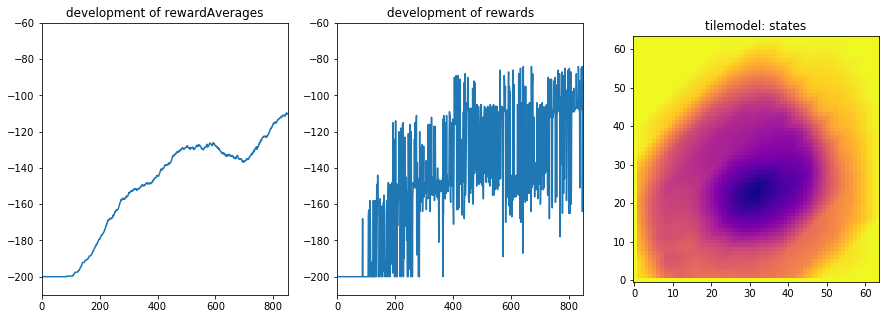

evaluation reset
cycle 1 starts:
Episode 849 done: steps: 108, r-average: -119.8, arrived 708(83.3%), maxReward: -83.0 in 549, best average: -116.7 in 739

cycle 1 done:
number episodes: 850
first time arrived in episode: 88
car arrived: 708 (83.3%)
best reward: -83.0 in episode 549
best average: -116.7 in episode 739
problem solved:False
states: max:0.14, mean: -4.41


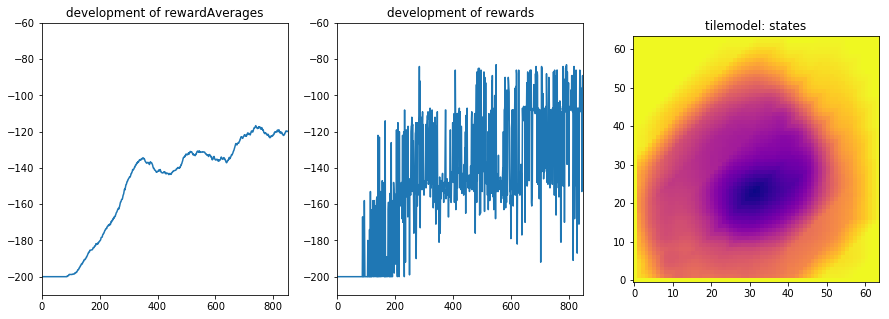

evaluation reset
cycle 2 starts:
Episode 849 done: steps: 84, r-average: -116.3, arrived 700(82.4%), maxReward: -83.0 in 823, best average: -116.3 in 849

cycle 2 done:
number episodes: 850
first time arrived in episode: 93
car arrived: 700 (82.4%)
best reward: -83.0 in episode 823
best average: -116.3 in episode 849
problem solved:False
states: max:0.02, mean: -4.47


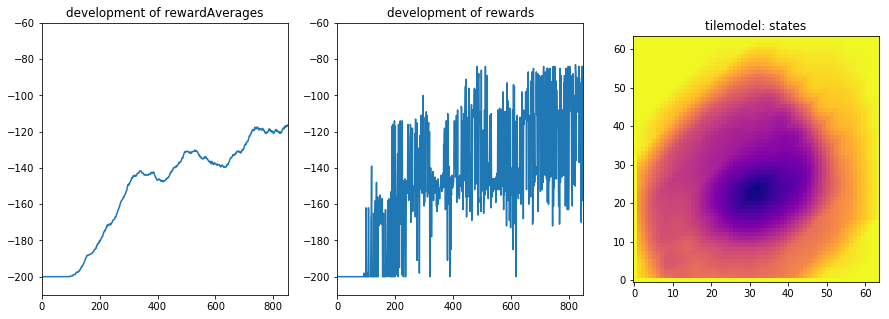

evaluation reset
cycle 3 starts:
Episode 849 done: steps: 135, r-average: -119.0, arrived 706(83.1%), maxReward: -83.0 in 573, best average: -117.3 in 844

cycle 3 done:
number episodes: 850
first time arrived in episode: 95
car arrived: 706 (83.1%)
best reward: -83.0 in episode 573
best average: -117.3 in episode 844
problem solved:False
states: max:0.00, mean: -4.43


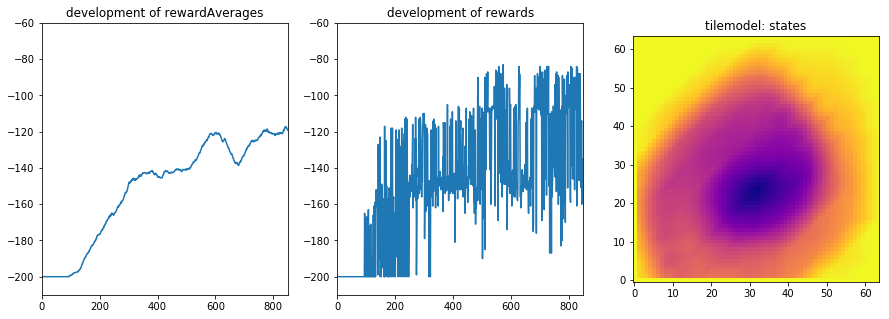

evaluation reset
cycle 4 starts:
Episode 849 done: steps: 144, r-average: -122.0, arrived 708(83.3%), maxReward: -83.0 in 580, best average: -117.2 in 762

cycle 4 done:
number episodes: 850
first time arrived in episode: 96
car arrived: 708 (83.3%)
best reward: -83.0 in episode 580
best average: -117.2 in episode 762
problem solved:False
states: max:0.06, mean: -4.44


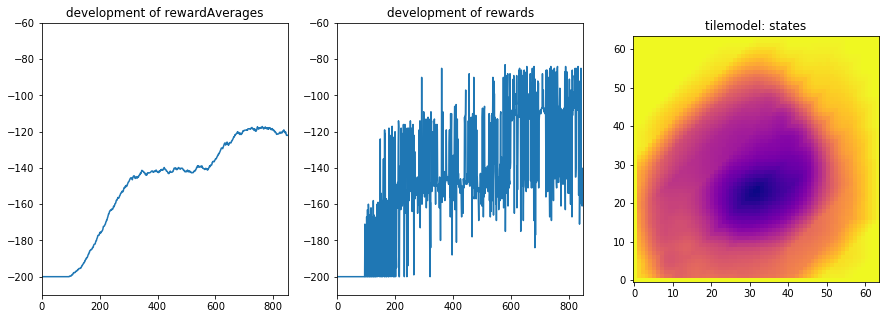

evaluation reset
cycle 5 starts:
Episode 849 done: steps: 107, r-average: -118.0, arrived 704(82.8%), maxReward: -83.0 in 734, best average: -111.2 in 787

cycle 5 done:
number episodes: 850
first time arrived in episode: 79
car arrived: 704 (82.8%)
best reward: -83.0 in episode 734
best average: -111.2 in episode 787
problem solved:False
states: max:0.05, mean: -4.40


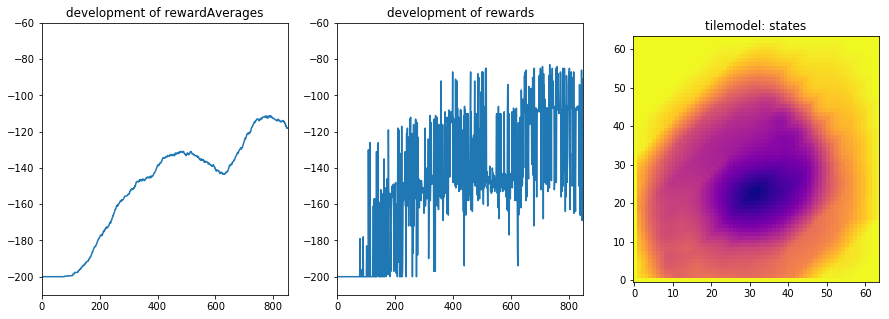

test finished after 6 runs
input: policy: <function policy at 0x0000019DA609ED90>, lambda: 0.2
first arrival: min: 79, max: 96, mean: 90, std: 5.8
nb of arrival: min: 700, max: 708, mean: 705, std: 2.9
nb of arrival: min: 82%, max: 83%, mean: 83%, std: 0.3%
best reward  : min: -84, max: -83, mean: -83, std: 0.4
in episode   : min: 549, max: 823, mean: 650, std: 98.4
best average : min: -117, max: -110, mean: -115, std: 3.1
in episode   : min: 739, max: 849, mean: 804, std: 44.1
prblem solved: min: 0, max: 1, mean: 0, std: 0.4


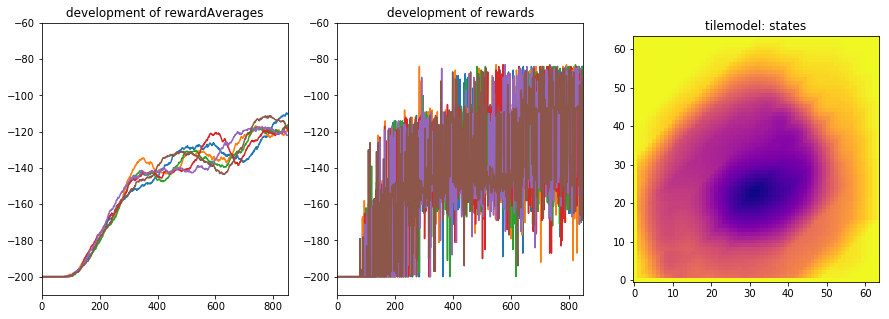

In [7]:
def policy(Q,epsilon):    
    if epsilon>0.0 and random.random() < epsilon:
        return env.action_space.sample()
    else: 
        return np.argmax(Q) 

def decayFunction(episode, pName):
    global nbEpisodes,policyP
    param=policyP[pName]
    if param['strategy']==0:
        return 1/((episode+1)**2)
    elif param['strategy'] ==1:
        return 1/(episode+1)
    elif param['strategy'] ==2:
        return (0.5)**episode+0.05
    elif param['strategy'] ==3:
        return 0.05
    elif param['strategy'] ==4:
        return max(param['start']-episode/param['interval'], param['base'])
    elif param['strategy'] ==5:
        return 0.5*(0.5**episode)+0.5
    elif param['strategy'] ==6:
        if episode < 20:
            return 0.5
        elif episode < 100:
            return 0.25
        else:
            return 0.1
    else:
        return param['static']
    
for cycle in range(nbCycles):
    #old evaluation
    lastDelta=-1000.0
    colorplot=np.empty([tileModel.nbTilings*tileModel.gridSize,tileModel.nbTilings*tileModel.gridSize],dtype=str)

    #prepare cycle
    tileModel.resetStates()
    evaluation.reset()
    evaluation.CycleStart(cycle)

    for episode in range(nbEpisodes):
    
        # decay - if administrated the parameters
        epsilon=decayFunction(episode, 'epsilon')
        gamma=decayFunction(episode, 'gamma')
        alpha=decayFunction(episode, 'alpha')
        alpha/=tileModel.nbTilings
        
        # prepare the model
        state = env.reset()
        eligibilityTraces.reset()
        Q=tileModel.getQ(state)
        action = policy(Q,epsilon)

        #prepare evaluation
        rewardAccumulated =0
        deltaQAs=[0.0]
   
        for t in range(nbTimesteps):
            env.render()
            state_next, reward, done, info = env.step(action)
            rewardAccumulated+=reward
            ### print('\n--- step action:',action,'returns: reward:', reward, 'state_next:', state_next)
            if done:
                evaluation.EpiTrack(episode,t,rewardAccumulated)
                evaluation.EpiEval(episode,t)
                if plotInterval>0 and (episode+1)%plotInterval == 0:
                    fig = plt.figure(figsize=(15,10))
                    eligibilityTraces.plotStates(fig.add_subplot(121))
                    tileModel.plot(fig.add_subplot(122))
                    plt.show()
                break

            #update Q(S,A)-Table according to:
            #Q(S,A) <- Q(S,A) + α (R + γ Q(S’, A’) – Q(S,A))
        
            #start with the information from the old state:
            #difference between Q(S,a) and actual reward
            #problem: reward belongs to state as whole (-1 for mountain car), Q[action] is the sum over several features
            
            #now we choose the next state/action pair:
            Q_next=tileModel.getQ(state_next)
            action_next=policy(Q_next,epsilon)
            action_QL=policy(Q_next,0.0)   

            if policySARSA:
                action_next_learning=action_next
            else:
                action_next_learning=action_QL

        
            # take into account the value of the next (Q(S',A') and update the tile model
            deltaQA=(reward + gamma * Q_next[action_next_learning] - Q[action])
            
            deltaQAs.append(deltaQA)
            
            if sarsaLambda < 0.0:              #TD(0)
                tileModel.updateQ(state, action, alpha*deltaQA)
            else:                         # eligibilityTraces, TD(lambda)
                eligibilityTraces.addOne(tileModel,state, action)
                eligibilityTraces.addDelta(tileModel,alpha*deltaQA)
                eligibilityTraces.multiply(sarsaLambda*gamma)
        
            # prepare next round:
            state=state_next
            action=action_next
            Q=Q_next
               
        if printEpisodeResult:
            #evaluation of episode: development of deltaQA
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            ax1.plot(range(len(deltaQAs)),deltaQAs,'-')
            ax1.set_title("after episode:  {} - development of deltaQA".format(episode))
            plt.show()

            #evaluation of episode: states
            plotInput=tileModel.preparePlot()
            ### print ('states:', tileModel.states)
            ### print ('plotInput:', plotInput)
    
            fig = plt.figure()
            ax2 = fig.add_subplot(111, projection='3d')
    
            x=range(tileModel.nbTilings*tileModel.gridSize)
            y=range(tileModel.nbTilings*tileModel.gridSize)
            yUnscaled=y*tileModel.gridWidth[0]+tileModel.obsLow[0]
            xUnscaled=x*tileModel.gridWidth[1]+tileModel.obsLow[1]


            colors=['r','b','g']
            labels=['back','neutral','forward']
            for i in range(tileModel.nbActions):
                ax2.plot_wireframe(xUnscaled,yUnscaled,plotInput[x,y,i],color=colors[i],label=labels[i])

            ax2.set_xlabel('velocity')
            ax2.set_ylabel('position')
            ax2.set_zlabel('action')
            ax2.set_title("after episode:  {}".format(episode))
            ax2.legend()
            plt.show()

            #colorplot=np.empty([tileModel.nbTilings*tileModel.gridSize,tileModel.nbTilings*tileModel.gridSize],dtype=str)
            minVal=np.zeros(3)
            minCoo=np.empty([3,2])
            maxVal=np.zeros(3)
            maxCoo=np.empty([3,2])
            for ix in x:
                for iy in y:
                    if 0.0 <= np.sum(plotInput[ix,iy,:]) and np.sum(plotInput[ix,iy,:])<=0.003:
                        colorplot[ix,iy]='g'
                    elif colorplot[ix,iy]=='g':
                        colorplot[ix,iy]='blue'
                    else:
                        colorplot[ix,iy]='cyan'
                

            xUnscaled=np.linspace(tileModel.obsLow[0], tileModel.obsHigh[0], num=tileModel.nbTilings*tileModel.gridSize)
            yUnscaled=np.linspace(tileModel.obsLow[1], tileModel.obsHigh[1], num=tileModel.nbTilings*tileModel.gridSize)

            fig = plt.figure()
            ax3 = fig.add_subplot(111)
    
            for i in x:
                ax3.scatter([i]*len(x),y,c=colorplot[i,y],s=75, alpha=0.5)

            #ax3.set_xticklabels(xUnscaled)
            #ax3.set_yticklabels(yUnscaled)
            ax3.set_xlabel('velocity')
            ax3.set_ylabel('position')
            ax3.set_title("after episode:  {} visited".format(episode))
            plt.show()
        
    evaluation.CycleTrack()
    evaluation.CycleEval(cycle,tileModel)

    
evaluation.TestEval(nbCycles, policy, sarsaLambda, tileModel)